In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# install requirements
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install transformers==4.25.1 timm==0.4.12 fairscale==0.4.4
    !git clone https://github.com/salesforce/BLIP
    %cd BLIP


Running in Colab.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 11.5 MB/s eta 0:00:00
  Using cached timm-0.4.12-py3-none-any.whl (376 kB)
  Using cached fairscale-0.4.4-py3-none-any.whl
  Using cached huggingface_hub-0.16.4-py3-none-any.whl (268 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 29.5 MB/s eta 0:00:00
Cloning into 'BLIP'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 277 (delta 137), reused 136 (delta 135), pack-reused 112
Receiving objects: 100% (277/277), 7.03 MiB | 23.46 MiB/s, done.
Resolving deltas: 100% (153/153), done.
/content/BLIP/BLIP/BLIP


In [63]:
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_demo_image(image_size,device, img_url):
    # img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
    try:
      raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
    except:
      raw_image = Image.open(img_url)
    w,h = raw_image.size
    display(raw_image.resize((image_size,image_size)))

    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])
    image = transform(raw_image).unsqueeze(0).to(device)
    return image

# Image Caption

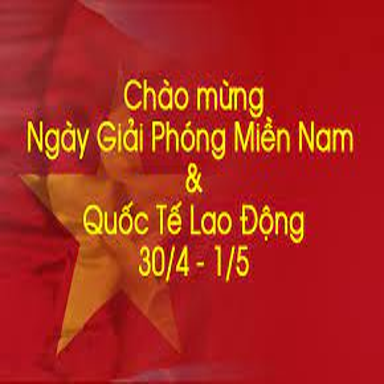

reshape position embedding from 196 to 576
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth
caption: a chinese flag with the words, ` ` ` ` ` ` ` ` `


In [94]:
from models.blip import blip_decoder

image_size = 384
image = load_demo_image(image_size=image_size,device=device,
                        img_url = "/content/drive/MyDrive/AIC_notebook/gp.jpeg")

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'

model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

with torch.no_grad():
    # beam search
    caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5)
    # nucleus sampling
    # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5)
    print('caption: '+caption[0])

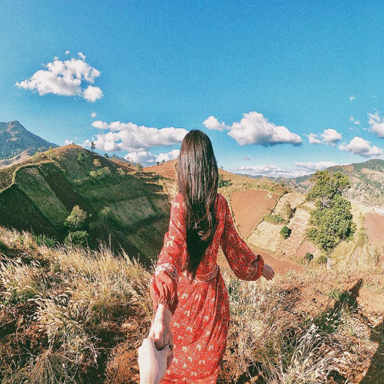

reshape position embedding from 196 to 576
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth
caption: a woman in a red dress


In [83]:
image_size = 384
image = load_demo_image(image_size=image_size,device=device,
                        img_url = "https://i-ngoisao.vnecdn.net/2020/08/03/chu3-7131-1596443349.jpg")

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'

model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

with torch.no_grad():
    # beam search
    caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5)
    # nucleus sampling
    # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5)
    print('caption: '+caption[0])

# Features extractor

In [41]:
import numpy as np
def cosine_similarity(feature1, feature2):
    return np.dot(feature1, feature2) / (np.linalg.norm(feature1) * np.linalg.norm(feature2))

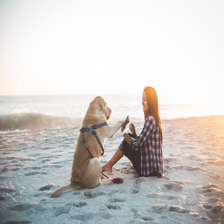

reshape position embedding from 576 to 196
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth


In [70]:
from models.blip import blip_feature_extractor

image_size = 224

image = load_demo_image(image_size=image_size, device=device, img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg')

model = blip_feature_extractor(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

caption = 'a woman sitting on the beach with a dog'

multimodal_feature = model(image, caption, mode='multimodal')[0,0]
image_feature = model(image, caption, mode='image')[0,0]
text_feature = model(image, caption, mode='text')[0,0]

In [66]:
print(image_feature.shape)
print(type(image_feature))
print(text_feature.shape)
print(multimodal_feature.shape)

torch.Size([768])
<class 'torch.Tensor'>
torch.Size([768])
torch.Size([768])


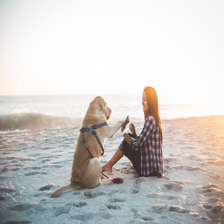

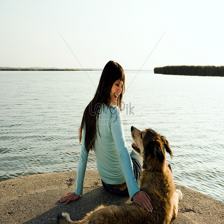

text 0.78563905
Image 0.7201835


In [71]:
caption1 = "i'm playing football at home"
caption2 = "I'm playing soccer"
caption = 'a woman sitting on the beach with a dog'
image_size = 224
image1 = load_demo_image(image_size=image_size, device=device,
                         img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg')
image2 = load_demo_image(image_size=image_size, device=device,
                         img_url = "/content/drive/MyDrive/AIC_notebook/woman_dog.jpg")
image_feature1 = model(image1, caption, mode='image')[0,0]
image_feature2 = model(image2, caption, mode='image')[0,0]
text_feature1 = model(image, caption1, mode='text')[0,0]
text_feature2 = model(image, caption2, mode='text')[0,0]
text_feature = model(image, caption, mode='text')[0,0]
similarity = cosine_similarity(text_feature1.detach().numpy(), text_feature2.detach().numpy())
print("text", similarity)
similarity = cosine_similarity(image_feature1.detach().numpy(), image_feature2.detach().numpy())
print("Image", similarity)

In [74]:
image_feature1 /= image_feature1.norm(dim=-1, keepdim=True)
text_feature /= text_feature.norm(dim=-1, keepdim=True)
similarity = cosine_similarity(image_feature1.detach().numpy(), text_feature.detach().numpy())
print("Image", similarity)

Image -0.05405589


# Matching text and image

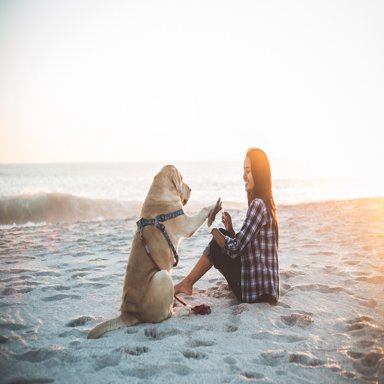

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth


In [84]:
from models.blip_itm import blip_itm

image_size = 384
image = load_demo_image(image_size=image_size,device=device,
                        img_url = "https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg")

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth'

model = blip_itm(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device='cpu')

In [78]:
%time
cap_lst = ['a woman sitting on the beach with a cat', 'a woman sitting on the beach with a dog', 'woman and dog', 'woman at the beach']
for caption in cap_lst:
  print('text: %s' %caption)
  itm_output = model(image,caption,match_head='itm')
  itm_score = torch.nn.functional.softmax(itm_output,dim=1)[:,1]
  print('The image and text is matched with a probability of %.4f'%itm_score)

  itc_score = model(image,caption,match_head='itc')
  print('The image feature and text feature has a cosine similarity of %.4f'%itc_score)

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 33.6 µs
text: a woman sitting on the beach with a cat
The image and text is matched with a probability of 0.0246
The image feature and text feature has a cosine similarity of 0.4330
text: a woman sitting on the beach with a dog
The image and text is matched with a probability of 0.9960
The image feature and text feature has a cosine similarity of 0.5262
text: woman and dog
The image and text is matched with a probability of 0.4305
The image feature and text feature has a cosine similarity of 0.4129
text: woman at the beach
The image and text is matched with a probability of 0.1145
The image feature and text feature has a cosine similarity of 0.3463


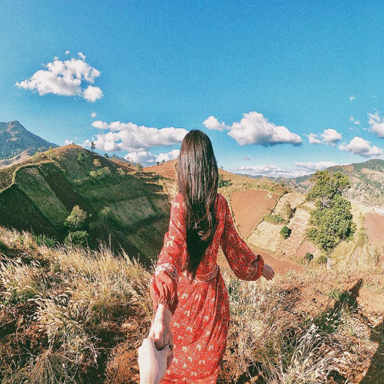

text: a woman sitting on the beach with a cat
The image and text is matched with a probability of 0.0006
The image feature and text feature has a cosine similarity of 0.3276
text: a woman in a red dress
The image and text is matched with a probability of 0.5851
The image feature and text feature has a cosine similarity of 0.3721
text: woman and dog
The image and text is matched with a probability of 0.0537
The image feature and text feature has a cosine similarity of 0.3271
text: một người phụ nữ mặc đồ đỏ, quay lưng lại và đứng trên đồi
The image and text is matched with a probability of 0.0414
The image feature and text feature has a cosine similarity of 0.2123
text: woman at the beach
The image and text is matched with a probability of 0.0020
The image feature and text feature has a cosine similarity of 0.3251
text: a woman wearing red, her back turned and standing in the hills
The image and text is matched with a probability of 0.9993
The image feature and text feature has a cosine

In [91]:
cap_lst = ['a woman sitting on the beach with a cat', 'a woman in a red dress', 'woman and dog',
           'một người phụ nữ mặc đồ đỏ, quay lưng lại và đứng trên đồi',
           'woman at the beach', 'a woman wearing red, her back turned and standing in the hills']
image = load_demo_image(image_size=image_size,device=device,
                        img_url = "https://i-ngoisao.vnecdn.net/2020/08/03/chu3-7131-1596443349.jpg")
for caption in cap_lst:
  print('text: %s' %caption)
  itm_output = model(image,caption,match_head='itm')
  itm_score = torch.nn.functional.softmax(itm_output,dim=1)[:,1]
  print('The image and text is matched with a probability of %.4f'%itm_score)

  itc_score = model(image,caption,match_head='itc')
  print('The image feature and text feature has a cosine similarity of %.4f'%itc_score)

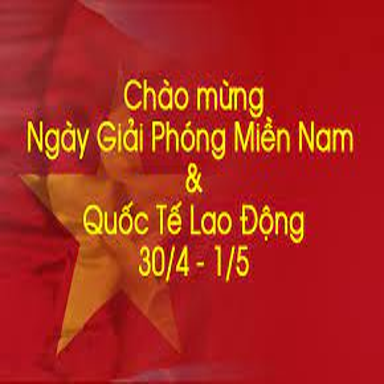

text: a woman sitting on the beach with a cat
The image and text is matched with a probability of 0.0005
The image feature and text feature has a cosine similarity of 0.2499
text: Ngay giai phong Mien Nam
The image and text is matched with a probability of 0.9998
The image feature and text feature has a cosine similarity of 0.4371
text: Ngày giải phóng miền Nam
The image and text is matched with a probability of 0.9998
The image feature and text feature has a cosine similarity of 0.4371
text: lá cờ đỏ sao vàng
The image and text is matched with a probability of 0.4990
The image feature and text feature has a cosine similarity of 0.4323
text: Southern Liberation Day
The image and text is matched with a probability of 0.3113
The image feature and text feature has a cosine similarity of 0.2918
text: a woman wearing red, her back turned and standing in the hills
The image and text is matched with a probability of 0.0004
The image feature and text feature has a cosine similarity of 0.2667
t

In [90]:
cap_lst = ['a woman sitting on the beach with a cat', 'Ngay giai phong Mien Nam', 'Ngày giải phóng miền Nam', 'lá cờ đỏ sao vàng',
           'Southern Liberation Day', 'a woman wearing red, her back turned and standing in the hills','Quốc tế lao động']
image = load_demo_image(image_size=image_size,device=device,
                        img_url = "/content/drive/MyDrive/AIC_notebook/gp.jpeg")
for caption in cap_lst:
  print('text: %s' %caption)
  itm_output = model(image,caption,match_head='itm')
  itm_score = torch.nn.functional.softmax(itm_output,dim=1)[:,1]
  print('The image and text is matched with a probability of %.4f'%itm_score)

  itc_score = model(image,caption,match_head='itc')
  print('The image feature and text feature has a cosine similarity of %.4f'%itc_score)

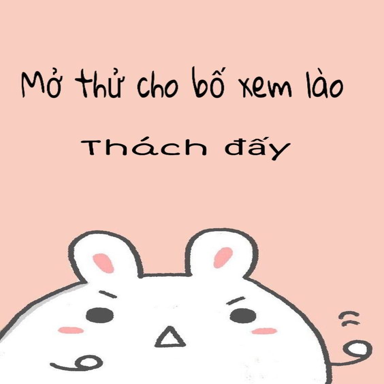

text: a woman sitting on the beach with a cat
The image and text is matched with a probability of 0.0001
The image feature and text feature has a cosine similarity of 0.2203
text: Ngay giai phong Mien Nam
The image and text is matched with a probability of 0.0216
The image feature and text feature has a cosine similarity of 0.2624
text: Ngày giải phóng miền Nam
The image and text is matched with a probability of 0.0216
The image feature and text feature has a cosine similarity of 0.2624
text: mở thử cho bố xem nào
The image and text is matched with a probability of 0.9999
The image feature and text feature has a cosine similarity of 0.3276
text: thách đấy
The image and text is matched with a probability of 0.9985
The image feature and text feature has a cosine similarity of 0.2848
text: ảnh vẽ của một con mèo trắng
The image and text is matched with a probability of 0.5931
The image feature and text feature has a cosine similarity of 0.3198
text: white cat of cartoon
The image and text

In [93]:
cap_lst = ['a woman sitting on the beach with a cat', 'Ngay giai phong Mien Nam',
           'Ngày giải phóng miền Nam', 'mở thử cho bố xem nào', 'thách đấy', 'ảnh vẽ của một con mèo trắng', 'white cat of cartoon']
image = load_demo_image(image_size=image_size,device=device,
                        img_url = "https://oppostyle.vn/wp-content/uploads/2022/07/hinh-nen-cute-co-chua-33.jpg")
for caption in cap_lst:
  print('text: %s' %caption)
  itm_output = model(image,caption,match_head='itm')
  itm_score = torch.nn.functional.softmax(itm_output,dim=1)[:,1]
  print('The image and text is matched with a probability of %.4f'%itm_score)

  itc_score = model(image,caption,match_head='itc')
  print('The image feature and text feature has a cosine similarity of %.4f'%itc_score)